## Calculate Action Space: 
This code serves to calculate the optimal action space for a racing track using normalizing the action space, adding Gaussian noise, and adjusting the data for clustering using K-Means.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy import stats
import math

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Path of the optimal racing line (.npy file)
fpath = "reInvent2019_track_ccw.npy"

# Change manually (this is only so that output files are named correctly)
TRACK_NAME = "smiley"

# Load the racing track data from the specified file
racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
racing_track = racing_track.tolist()[:-1]


In [3]:

# Uses previous and next coords to calculate the radius of the curve
# Pass a list with the format [[x1, y1], [x2, y2], [x3, y3]]
# Input 3 coordinates [[x1, y1], [x2, y2], [x3, y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (for clarity)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    # Calculate coefficients for the circle equation
    a = x1 * (y2 - y3) - y1 * (x2 - x3) + x2 * y3 - x3 * y2
    b = (x1 ** 2 + y1 ** 2) * (y3 - y2) + (x2 ** 2 + y2 ** 2) * (y1 - y3) + (x3 ** 2 + y3 ** 2) * (y2 - y1)
    c = (x1 ** 2 + y1 ** 2) * (x2 - x3) + (x2 ** 2 + y2 ** 2) * (x3 - x1) + (x3 ** 2 + y3 ** 2) * (x1 - x2)
    d = (x1 ** 2 + y1 ** 2) * (x3 * y2 - x2 * y3) + (x2 ** 2 + y2 ** 2) * (x1 * y3 - x3 * y1) + (x3 ** 2 + y3 ** 2) * (x2 * y1 - x1 * y2)

    # Calculate the radius or set to infinity if 'a' is zero
    try:
        r = abs((b ** 2 + c ** 2 - 4 * a * d) / abs(4 * a ** 2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# Needed to calculate the radius for the next track section
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # Use modulo to consider the track as cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Calculate the minimal radius for optimal speed calculation
    v_min_r = min(radius) ** 0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i ** 0.5) for i in radius]
        # Cap velocity at MAX_SPEED
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Look at the next n radii of points and take the minimum
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS + 1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i ** 0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# Check if the curve is left or right based on 3 coordinates
def is_left_curve(coords):

    # Flatten the list and assign to variables (for clarity)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
    return abs(abs(x1 - x2) ** 2 + abs(y1 - y2) ** 2) ** 0.5

In [4]:
# Set the number of points to look ahead for speed calculation
LOOK_AHEAD_POINTS = 5

# Set the minimum and maximum speeds for the car
MIN_SPEED = 1.5
MAX_SPEED = 4

# Calculate optimal speed based on the racing track and constraints
velocity = optimal_velocity(track=racing_track, 
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)


Constant multiple for optimal speed: 1.6984929935993094


Constant multiple for optimal speed: 1.6984929935993094


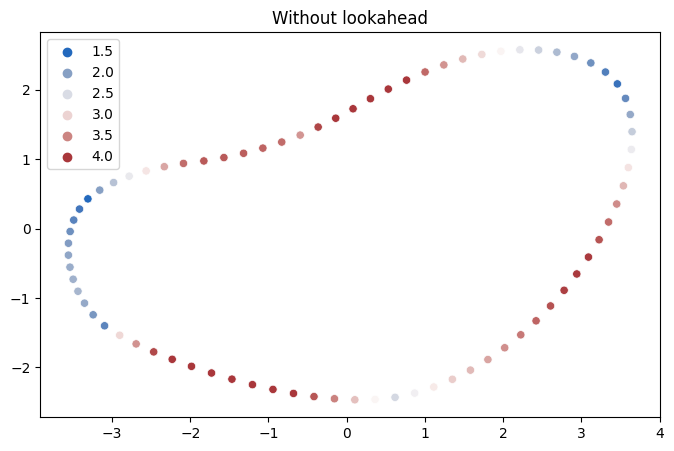

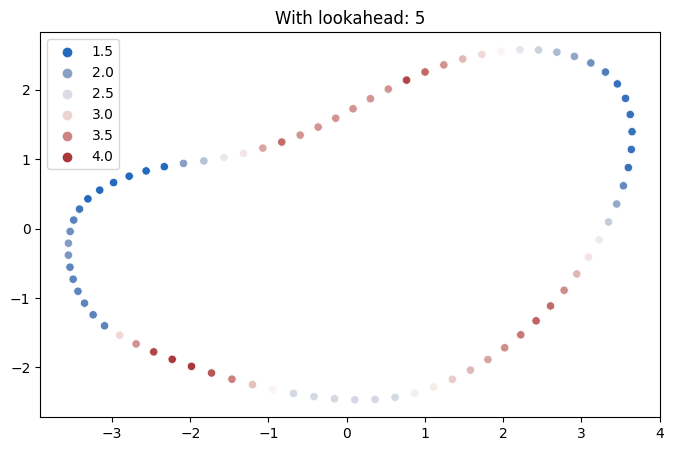

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

In [6]:
# Initialize an empty list to store distances to the previous points
distance_to_prev = []

# Calculate distances to the previous points and append to the list
for i in range(len(racing_track)):
    # Get indexes of the current and previous points
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    
    # Extract coordinates of the current and previous points
    coords = [racing_track[indexes[0]], racing_track[indexes[1]]]
    
    # Calculate the distance between the two points
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    
    # Append the calculated distance to the list
    distance_to_prev.append(dist_to_prev)
    
# Calculate time to reach each point based on distance and velocity
time_to_prev = [(distance_to_prev[i] / velocity[i]) for i in range(len(racing_track))]

# Calculate the total time to complete the track using perfect racing line and speeds
total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")


Total time for track, if racing line and speeds are followed perfectly: 8.01065150356399 s


In [7]:
# Create an empty list to store comprehensive track information
# Each entry will contain columns (x, y, speed, distance, time)
racing_track_everything = []

# Iterate through each point on the racing track
for i in range(len(racing_track)):
    # Extract relevant data for the current point
    x = racing_track[i][0]
    y = racing_track[i][1]
    speed = velocity[i]
    time = time_to_prev[i]
    
    # Append the data to the comprehensive track information list
    racing_track_everything.append([x, y, speed, time])

# Round the values to 5 decimal places
racing_track_everything = np.around(racing_track_everything, 5).tolist()


In [8]:
# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    # Get indexes for the current point and the next two points (cyclically)
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    # Extract coordinates of the current point and its neighbors
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    # Calculate the radius for this section of the track and append to the list
    radius.append(circle_radius(coords))

# Calculate whether each point is part of a left curve
left_curve = []
for i in range(len(racing_track)):
    # Get indexes for the current point and the next two points (cyclically)
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    # Extract coordinates for checking the curve direction
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    # Determine if the current section is part of a left curve and append result
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    # Determine the direction of the radius based on left_curve
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    # Append the radius with direction to the list
    radius_direction.append(radius_with_direction)

# Calculate steering angles with + and -
dist_wheels_front_back = 0.165  # meters
steering = []
for i in range(len(racing_track)):
    # Calculate the steering angle based on the radius with direction
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    # Append the calculated steering angle to the list
    steering.append(steer)
    
# Merge relevant lists into a DataFrame for actions (velocity and steering)
all_actions = pd.DataFrame({"velocity": velocity,
                            "steering": steering})


<Axes: ylabel='Density'>

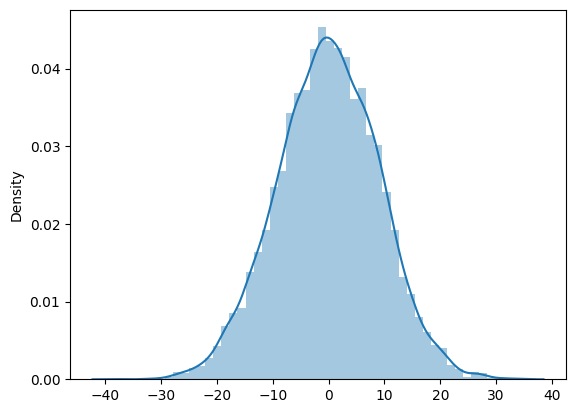

In [10]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)
steering_sd
sns.distplot(np.random.normal(0,steering_sd,10000))

<Axes: ylabel='Density'>

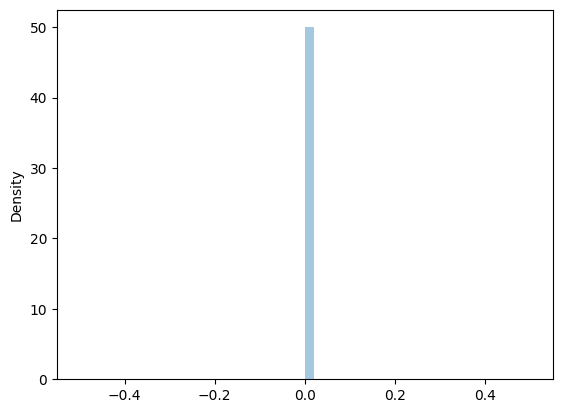

In [12]:
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)
velocity_sd
sns.distplot(np.random.normal(0,velocity_sd,10000))

In [14]:
# Create a copy of the original actions DataFrame for normalization
all_actions_norm = all_actions.copy()

# Get the length of the normalized actions DataFrame and set resampling parameters
all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Loop through each action in the DataFrame and add Gaussian noise
for i in range(all_actions_norm_len):
    # Get the true velocity and steering values for the current row
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    # Generate random samples with Gaussian noise for velocity and steering
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    # Create a DataFrame with normalized velocity and steering samples
    vs_norm = pd.DataFrame(np.column_stack([v_norm, s_norm]), columns=["velocity", "steering"])
    # Concatenate the normalized samples to the all_actions_norm DataFrame
    all_actions_norm = pd.concat([all_actions_norm, vs_norm], axis=0, ignore_index=True)

# Filter out actions with maximum speed to prevent overemphasis during clustering
# This is done because there might be disproportionately many points with max speed
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]

# Add initial actions to the action space to focus clustering on initial actions
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions, all_actions], axis=0, ignore_index=True)
# Concatenate the initial actions to the all_actions_norm DataFrame
all_actions_norm = pd.concat([all_actions_norm, add_initial_actions], axis=0, ignore_index=True)

# Display the shape of the normalized action space DataFrame
actions_shape = all_actions_norm.shape
print("Shape of normalized action space:", actions_shape)


Shape of normalized action space: (85826, 2)


In [15]:
# Assign the normalized actions to the variable X
X = all_actions_norm

# Calculate action space with KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with MinMaxScaler to bring all features within the same scale
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), columns=["velocity", "steering"])

# Apply KMeans clustering algorithm
# Removing 2 actions from KMeans to manually include low-speed & high-steering actions
n_clusters = 21 - 2  # Define the number of clusters
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

# Inverse transform the cluster centers to get interpretable values
minmax_scaler = MinMaxScaler()  # Re-initialize MinMaxScaler
X_minmax_fit = minmax_scaler.fit(X)  # Fit scaler on original data
# Inverse transform the cluster centers to get the original scale
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_),
                           columns=["velocity", "steering"])

# Add 2 manual actions to the action space
# This is because at the start of a new episode, the car may not start on the racing line
manual_actions = pd.DataFrame({"velocity": [MIN_SPEED, MIN_SPEED], "steering": [30, -30]})
X_centroids = pd.concat([X_centroids, manual_actions], ignore_index=True)

# Create a copy of the centroids as the final action space
action_space_e = X_centroids.copy()


In [16]:
# Create a subset of the action space containing only "steering" and "velocity" columns
action_space_for_json = action_space_e[["steering", "velocity"]].copy()

# Round the values to 4 decimal places for cleaner output
action_space_for_json = action_space_for_json.round(4)

# Rename the columns for the final JSON structure
action_space_for_json.columns = ["steering_angle", "speed"]

# Add an "index" column to keep track of the actions
action_space_for_json["index"] = action_space_for_json.index

# Convert the action space to JSON format
json_text = action_space_for_json.to_json(orient="records", lines=False)

# The resulting JSON text represents the action space
action_space_for_json


,steering_angle,speed,index
0,4.8407,3.7862,0
1,19.7756,1.6926,1
2,3.9219,2.4201,2
3,2.8405,3.0388,3
4,-4.9342,1.6309,4
5,-15.2059,3.3555,5
6,2.8202,3.4106,6
7,13.8187,2.9737,7
8,7.3117,1.5486,8
9,0.0695,1.9980,9
